# Implementation and evaluation of K-nearest neighbors (KNN) algorithm for handwritten digit recognition.
### Nina Gutzeit, Maximimilian Hingerl, Emma Kray, Johannes Müller
### July 2021

## Introduction
(...)

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from functions.Standardize import center
from functions.demo import demo

from functions.Load_data import load_the_pickle
train_labels, train_values = load_the_pickle('data/train_points.p')
test_labels, test_values = load_the_pickle('data/test_points.p')

## The data set
(insert description of data here: mnist, 28x28, csv)

Below we can see how a random sample of 25 images looks:

<Figure size 720x720 with 0 Axes>

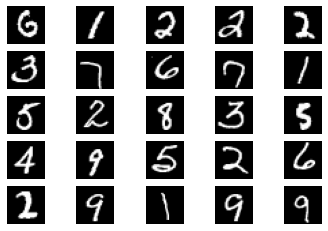

In [2]:
# loading a selection of images
fig = plt.figure(figsize=(10,10))
a = np.random.randint(0,59975)
b = a +25
fig = plt.figure()
for i in range (a,b):
    mat_data = train_values[i,:].reshape(28,28)
    fig.add_subplot(5, 5, i-a+1)
    plt.imshow(mat_data, cmap = 'gray')
    plt.axis('off')

plt.show()

## Data cleaning
The first step when dealing with such a data set is to check for errors or irregularities. Unexpected values such as NA values or outliers with intensity values outside of the range(0, 256) need to be dealt with. Possible solutions are removing the affected images or imputation of the individual values.   
There are no unusual entries:

In [3]:
# checking for NA and range


## Standardization
The data needs to be standardized for PCA. It is important that all pixels have the same magnitude/ weight. For example if the intensity values of one pixel position vary from 0 to 5 and another has values between 100 and 150, then the second pixel will dominate the principle components.

Standardization can refer to different operations. It can refer to re-scaling the values to a certain range, subtracting the mean from each value and/ or dividing by the standard deviation. Here centering and Z-transformation were implemented with the goal of comparing their performance.

Covariance is calculated by:     
$$\text{cov}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \left(X_i - \overline{X}\right)\left(Y_i - \overline{Y}\right)$$   

The covariance operation includes centering: $ (X_i - \overline{X}) $. The same is true for Z transformation and correlation:  

$$\dfrac{(X_i - \overline{X})} {\sigma _ {i}} ~~,~~~~~ \text{corr}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \dfrac {\left(X_i - \overline{X}\right)}{\sigma_{x}}\dfrac{\left(Y_i - \overline{Y}\right)}{\sigma_{y}}$$
  
The mean and standard deviation of the training data set are used to standardize the images of digits to be predicted. Therefore it was necessary to write functions with two arrays as an input. One matrix is standardized using the mean and std of the other matrix containing the training data.    

One challenge the data set provides is that there are pixel positions in the training data set where every image has the same intensity value. This means that the standard deviation is 0. Mathematically this leads to undefined values in the correlation matrix which the program returns as 'Nan'. Running the final algorithm over this data with the Nan values leads to a very poor result of less than 10% correct digit predicitions.    

However these variables include no information that distinguishes a "1" from a "2" because the values are the same accross all digits. Therefore instead of replacing 'Nan's with another value, these variables could be removed entirely. The same variables need to be removed in the test images.

### Comparing standardization methods

In [4]:
# Centered data performance on final algorithm:
false_assignments_centered, hit, miss = demo(1000, scale=False)

print('Correctly predicted digits: ', hit) 
print('Incorrectly predicted digits: ', miss)

C:\Users\Emma Kray\Documents\Uni\FS4_SS2021\DataAnalysis\2021-topic-04-team-02\functions\Standardize.py:67: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Y == "None":


Correctly predicted digits:  966
Incorrectly predicted digits:  34


In [5]:
# Z-transformed data performance:
false_assignments_z_transformed, hit, miss = demo(1000, scale=True)

print('Correctly predicted digits: ', hit) 
print('Incorrectly predicted digits: ', miss)

C:\Users\Emma Kray\Documents\Uni\FS4_SS2021\DataAnalysis\2021-topic-04-team-02\functions\Standardize.py:78: RuntimeWarning: invalid value encountered in true_divide
  c_mat = c_mat / std_dev[:, None]
C:\Users\Emma Kray\Documents\Uni\FS4_SS2021\DataAnalysis\2021-topic-04-team-02\functions\Standardize.py:79: RuntimeWarning: invalid value encountered in true_divide
  c_mat = c_mat / std_dev[None, :]


Correctly predicted digits:  960
Incorrectly predicted digits:  40


Their performance is very similar, however the program is slightly more accurate when the data is only centered. To compare the 'quality' of the performances, here is a comparison of which digits are incorrectly identified:

(array([0., 1., 7., 4., 5., 2., 2., 4., 9.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

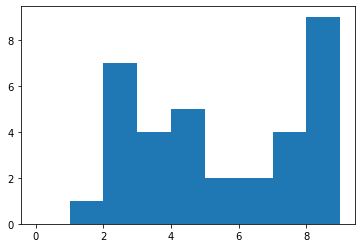

In [6]:
# Centered missed digits
plt.hist(false_assignments_centered, bins= range(0,10))

(array([ 0.,  1.,  7.,  7.,  4.,  2.,  3.,  4., 12.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

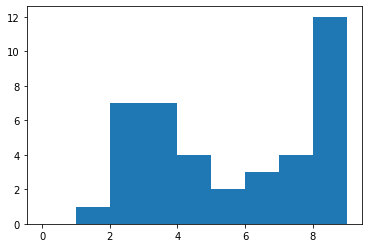

In [7]:
# Z transformed missed digits
plt.hist(false_assignments_z_transformed, bins= range(0,10))

The distribution of falsely assigned digits is not noticebly different between the two methods. the plots reveal an interesting trend that some digits are more frequently misassigned than others.  
Because the centered data performs better and does not require the removal of missing values, it is selected as the default for the program.

## The knn algorithm
### distance methods
The knn algorithm classifies the test-dataset based on the distances between a single test-datapoint and all points of the training dataset. These distances are then being sorted by
size and the k smallest distances were selected. By looking at the labels of these k nearest neighbours, the algorithm decides based on the major vote which label fits best for the tested data point.
There are many different ways to calculate distances, two methods were tested: The euclidean and the manhattan distance. The result of the knn algorithm delivers with both distance methods very good results. There was no big time difference.

In [ ]:
import functions.KNN_predict as knn
#run code and compare between manhattan and euclidean + nice plot?


### ways of implementing knn

#### slow and simple
The first version of the algorithm uses knn-method as a function which classifies one test data point at a time. The code needs to iterate 10000 times over that function which results in a run time of over 6 minutes.
The attempt to avoid that by directly calculating all pairwise distances in one step using the np.newaxis function failed. By adding another axis to the training set and a different new axis to the test set a temporary matrix with the dimensions (60000,10000,45) would be generated.
Performing this operation need more than 200 GB of RAM, this seemed like a dead end.

#### introducing multiprocessing
After the failed attempt, python multiprocessing was integrated into the functioning but slow algortithm. Instead of running one process that iterates 10000 times over the knn function,
the multiprocessing function gets a range of numbers with which it should run the function and than creates a "pool" of tasks and starts an individual python process for each task-batch. That means that based on the system which runs the code the function creates multiple processes at once and splits the workload onto all processing cores of the computer.
For example on a computer with 4 cores the code can run 4 processes at a time efficently, due to that optimization we could bring down our run time from about 6 minutes to 100 seconds.

In [ ]:
#comparison between function with and without multiprocessing

#### quick and complicated
kd-trees

In [ ]:
#

### weighted knn


In [ ]:
#comparison weighted and normal knn